In [1]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import and standardise data

maybe I shouldn't have fitted a standard_scaler to each sample? this makes it harder to meaningfully invert, especially with unseen test data

In [2]:
def get_data(ntrain, ntest):
    # amount of subsampling
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = scipy.io.loadmat("../burgers_data/burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]

    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]

    x_train = (x_branch_train, grid)
    x_test = (x_branch_test, grid)
    return x_train, y_train, x_test, y_test

n_samples_train = 500
n_samples_test = 1000

x_train, y_train, x_test, y_test = get_data(n_samples_train, n_samples_test)

domain = x_train[1]

print(x_train[0].shape, x_train[1].shape, y_train.shape)
print(x_test[0].shape, x_test[1].shape, y_test.shape)

standardise_data = False

# standardise data
if standardise_data:
    x_train_standardised = np.zeros_like(x_train[0])
    for i in range(x_train_standardised.shape[0]):
        x_scaler = skl.preprocessing.StandardScaler().fit(x_train[0][i, :].reshape(-1, 1))
        x_train_standardised[i, :] = x_scaler.transform(x_train[0][i, :].reshape(-1, 1)).flatten()
    x_train = x_train_standardised

    y_train_standardised = np.zeros_like(y_train)
    for i in range(y_train_standardised.shape[0]):
        y_scaler = skl.preprocessing.StandardScaler().fit(y_train[i, :].reshape(-1, 1))
        y_train_standardised[i, :] = y_scaler.transform(y_train[i, :].reshape(-1, 1)).flatten()
    y_train = y_train_standardised
else:
    x_train = x_train[0]
    y_train = y_train

(500, 128) (128, 1) (500, 128)
(1000, 128) (128, 1) (1000, 128)


Training example

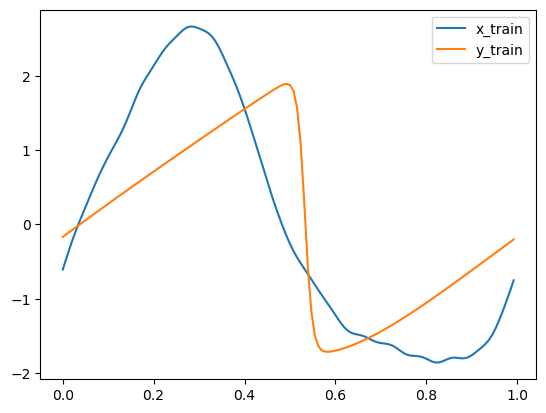

-2.0816681711721685e-17 1.6016937834376712
2.0782471923941337e-10 1.14947919151746


In [3]:
index_to_plot = 127

plt.figure()
plt.plot(domain, x_train[index_to_plot, :].T, label="x_train")
plt.plot(domain, y_train[index_to_plot, :].T, label="y_train")
plt.legend()
plt.show()

print(x_train[index_to_plot, :].mean(), x_train[index_to_plot, :].std())
print(y_train[index_to_plot, :].mean(), y_train[index_to_plot, :].std())

# Training

Check the PCA components

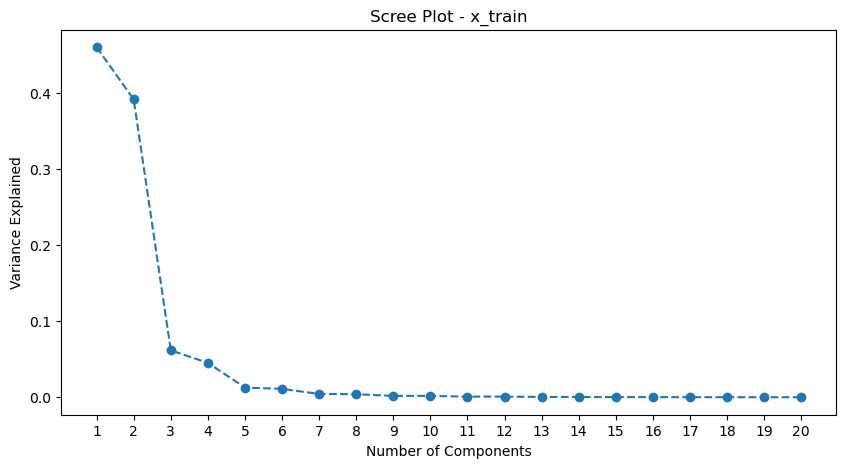

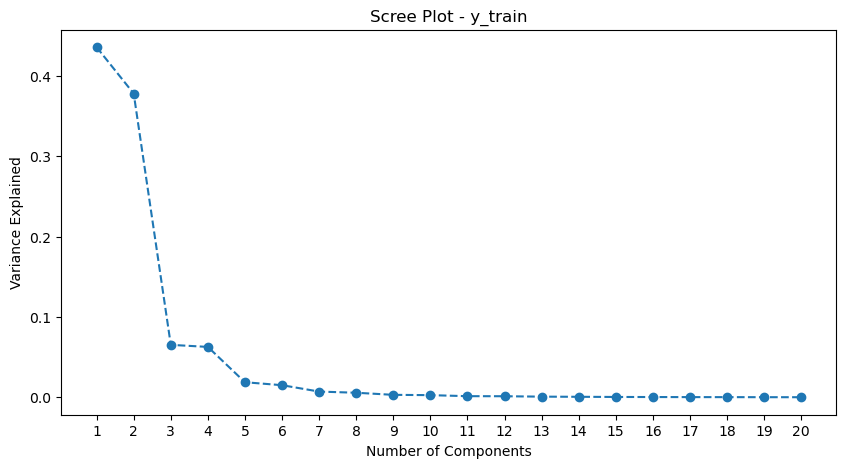

In [4]:
x_pca = PCA(n_components=20)
y_pca = PCA(n_components=20)
x_lowdim = x_pca.fit_transform(x_train)
y_lowdim = y_pca.fit_transform(y_train)

x_explained_variance = x_pca.explained_variance_ratio_
y_explained_variance = y_pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(x_explained_variance) + 1), x_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - x_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(x_explained_variance) + 1))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(y_explained_variance) + 1), y_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - y_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(y_explained_variance) + 1))
plt.show()

Train

In [6]:
debug = True
multiinput = False

low_dim_x = 10
low_dim_y = 10

start_lengthscale = 1.0 # here I choose where to start the lengthscale optimisation for each dimension of the input

if multiinput:
    ls = np.full((low_dim_x), start_lengthscale)
else:
    ls = start_lengthscale
    low_dim_y = low_dim_x

GP_params = {'kernel': gpx.kernels.RBF(lengthscale = ls), 'mean_function': gpx.mean_functions.Zero()}

reg = first_model(low_dim_x=low_dim_x, low_dim_y=low_dim_y, low_dim_regressor='GP', GP_params=GP_params, multiinput=multiinput)
reg.fit(x_train, y_train, save=True, return_bounds=True)

print(reg.low_dim_regressor_list)

if debug and low_dim_x == 2:
    fig, ax = plt.subplots(1, low_dim_y, figsize=(5*low_dim_y, 5))
    for i in range(low_dim_y):
        x_PCA_1 = reg.X_train_low_dim[:, 0]
        x_PCA_2 = reg.X_train_low_dim[:, 1]
        y_PCA_i = reg.Y_train_low_dim[:, i]
        
        grid_x_PCA_1, grid_x_PCA_2 = np.meshgrid(np.linspace(x_PCA_1.min(), x_PCA_1.max(), 1000), np.linspace(x_PCA_2.min(), x_PCA_2.max(), 1000))
        grid_y_PCA_i = griddata((x_PCA_1, x_PCA_2), y_PCA_i, (grid_x_PCA_1, grid_x_PCA_2), method='linear')

        cf = ax[i].contourf(grid_x_PCA_1, grid_x_PCA_2, grid_y_PCA_i, levels=100, cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0))
        ax[i].scatter(x_PCA_1, x_PCA_2, c='k', s=5)
        fig.colorbar(cf, ax=ax[i])
        
        ax[i].set_title(f"y_train PCA {i+1}")
        ax[i].set_xlabel("x_train PCA 1")
    ax[0].set_ylabel("x_train PCA 2")
    plt.show()
    fig, ax = plt.subplots(1, low_dim_y, figsize=(5*low_dim_y, 5))
    for i in range(low_dim_y):
        x_PCA_1 = reg.X_train_low_dim[:, 0]
        x_PCA_2 = reg.X_train_low_dim[:, 1]

        r = np.sqrt(x_PCA_1**2 + x_PCA_2**2)
        theta = np.arctan2(x_PCA_2, x_PCA_1)
        
        y_PCA_i = reg.Y_train_low_dim[:, i]
        
        grid_r, grid_theta = np.meshgrid(np.linspace(r.min(), r.max(), 1000), np.linspace(theta.min(), theta.max(), 1000))
        grid_y_PCA_i = griddata((r, theta), y_PCA_i, (grid_r, grid_theta), method='linear')

        cf = ax[i].contourf(grid_r, grid_theta, grid_y_PCA_i, levels=100, cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0))
        ax[i].scatter(r, theta, c='k', s=5)
        fig.colorbar(cf, ax=ax[i])
        
        ax[i].set_title(f"y_train PCA {i+1}")
        ax[i].set_xlabel("r")
    ax[0].set_ylabel("theta")
    plt.show()

(500, 10)
(500, 10)
GP


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 263.004120
         Iterations: 31
         Function evaluations: 119
         Gradient evaluations: 109
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(18.872149, dtype=float32), variance=Array(57.9529, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.39527726, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 272.921997
         Iterations: 22
         Function evaluations: 95
         Gradient evaluations: 84
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(20.386942, dtype=float32), variance=Array(66.44899, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.4054197, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 833.334595
         Iterations: 7
         Function evaluations: 85
         Gradient evaluations: 76
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(4.0877533, dtype=float32), variance=Array(1.0926286, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(1.2665498, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 827.582703
         Iterations: 11
         Function evaluations: 98
         Gradient evaluations: 86
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(6.558677, dtype=float32), variance=Array(2.7194605, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(1.252415, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 561.930725
         Iterations: 16
         Function evaluations: 157
         Gradient evaluations: 144
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(5.284874, dtype=float32), variance=Array(1.2568292e-07, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.74447286, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 507.058838
         Iterations: 6
         Function evaluations: 82
         Gradient evaluations: 71
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(3.3442996, dtype=float32), variance=Array(1.324344e-06, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.6670055, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 319.351105
         Iterations: 15
         Function evaluations: 149
         Gradient evaluations: 137
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(7.2376122, dtype=float32), variance=Array(7.398348e-08, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.45828506, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 262.492371
         Iterations: 14
         Function evaluations: 97
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(9.92713, dtype=float32), variance=Array(4.293882e-08, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.4090342, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 107.830635
         Iterations: 17
         Function evaluations: 96
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(11.43876, dtype=float32), variance=Array(1.34356934e-08, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.3002072, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 73.981598
         Iterations: 20
         Function evaluations: 167
         Gradient evaluations: 153
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(12.353864, dtype=float32), variance=Array(1.3549177e-09, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=500, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.2805565, dtype=float32))
[0.39619428 0.39600646 0.3959776  0.39603537 0.3964734  0.39614135
 0.39711273 0.395992   0.39596796 0.39614132 0.39753518 0.40670383
 0.3962328  0.39680523 0.39596793 0.39595836 0.39614135 0.39619908
 0.3961028  0.39599198 0.3959776  0.3959776  0.39655036 0.39666095
 0.39608356 0.39760232 0.39683408 0.39826375 0.39690134 0.39601612
 0.39617988 0.3960835  0.3960354  0.39602092 0.39673793 0.39604506
 0.3959776  0.39599684 0.39630494 0.39632422 0.39595354 0.39707422
 0.39739117 0.39604494 0.39

See how well the low dim regressor is doing

(500,)
(500,)
(500,)
(500,)
(500,)
(500,)
(500,)
(500,)
(500,)
(500,)


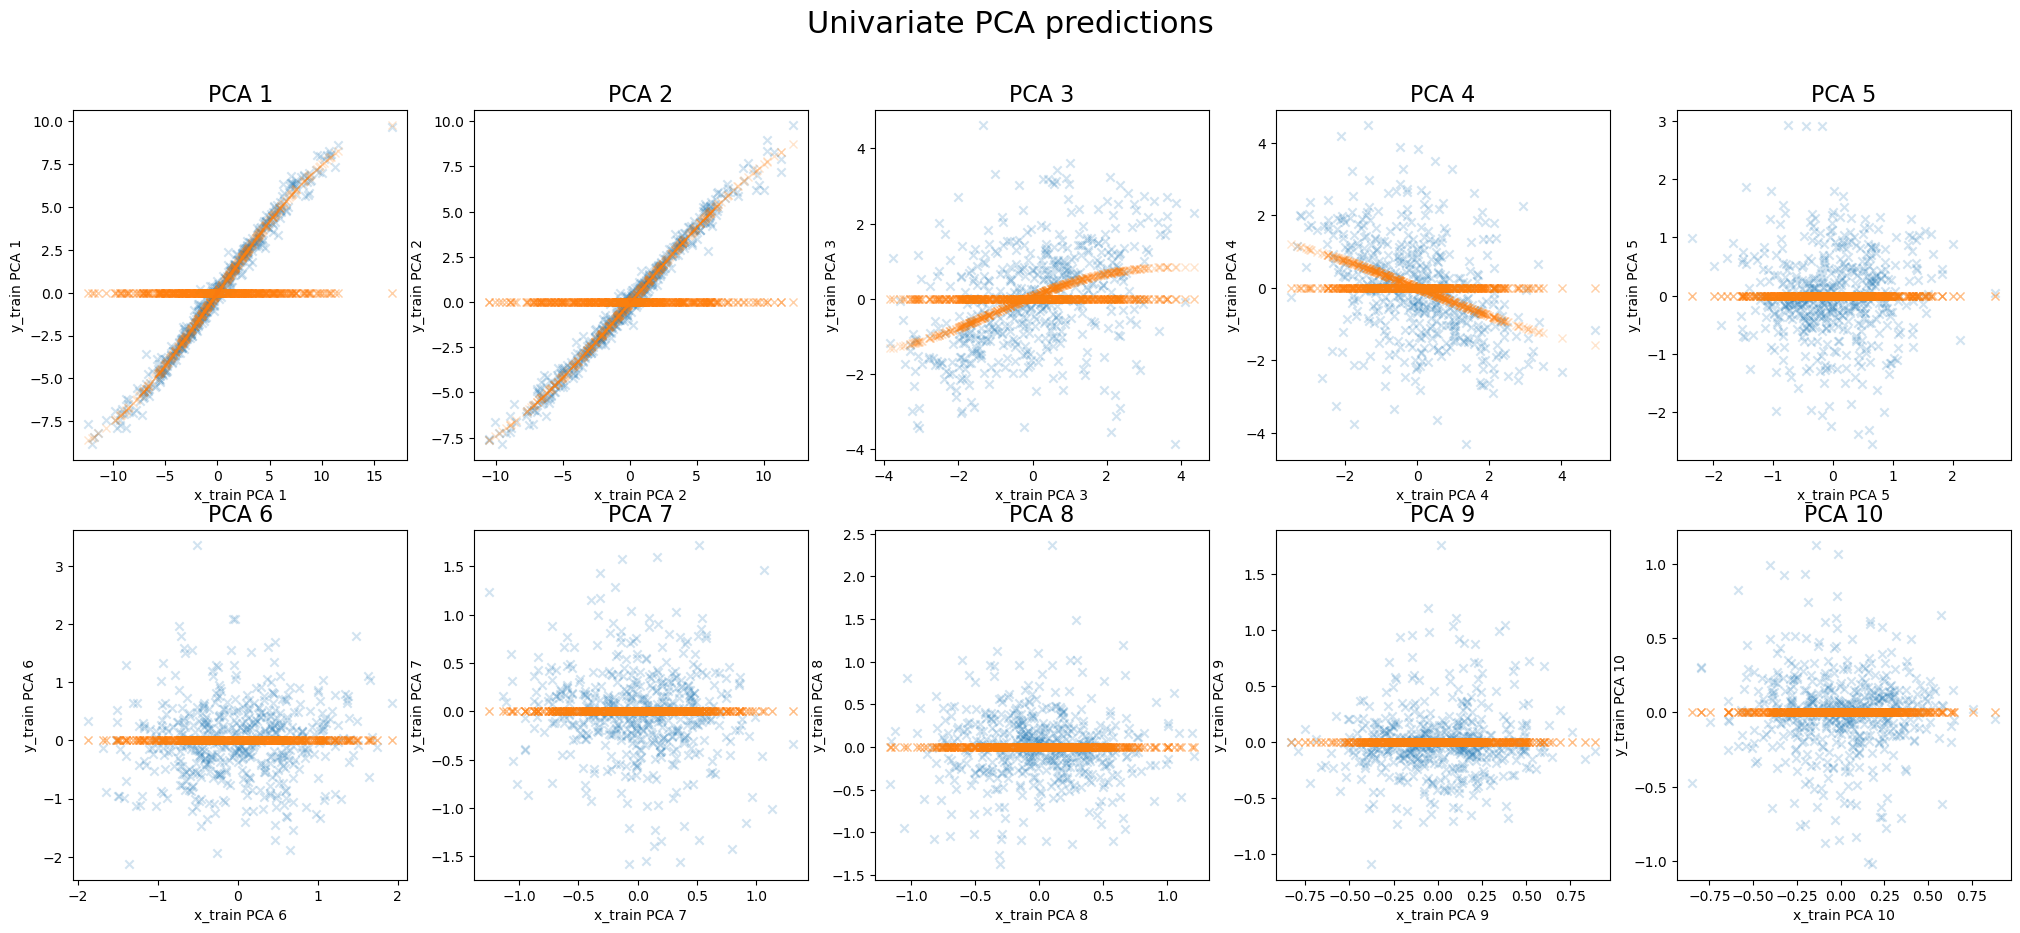

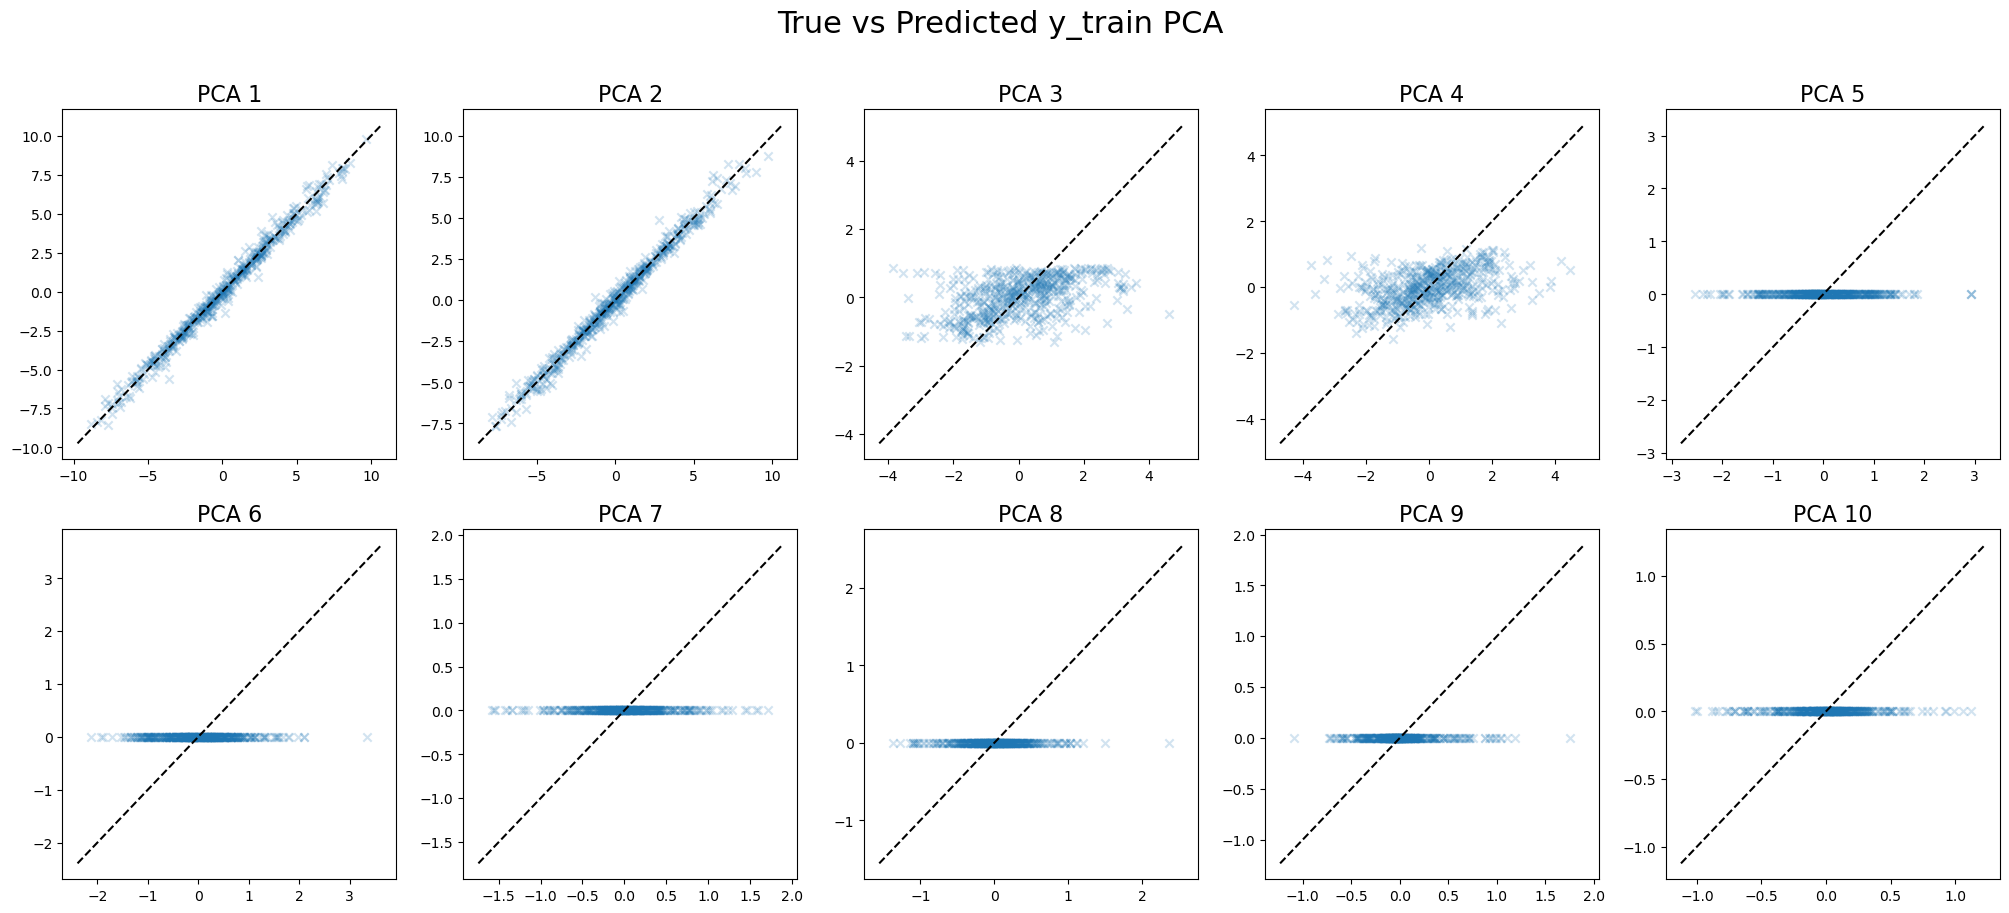

In [7]:
# assess how well the low-dimensional regression is doing

# if low_dim_x > 1:
#     plt.figure()
#     plt.scatter(reg.X_train_low_dim[:, 0], reg.X_train_low_dim[:, 1], marker='x', alpha=0.2)
#     plt.xlabel('PCA 1')
#     plt.ylabel('PCA 2')
#     plt.title('PCA of x_train (top two components)')
#     plt.show()

if low_dim_y is None:
    low_dim_y = y_train.shape[1]

n_rows = int(np.ceil(low_dim_y/5))



fig2, ax2 = plt.subplots(n_rows, 5, figsize=(25, n_rows*5))
fig2.suptitle('Univariate PCA predictions', fontsize=22)
if low_dim_x == 1:
    for i in range(low_dim_y):
        if n_rows == 1:
            sli = int(i%5)
        else:
            sli = int(np.floor((i)/5)), int(i%5)
        ax = ax2[sli]
        ax.scatter(reg.X_train_low_dim[:, 0], reg.Y_train_low_dim[:, i], marker='x', alpha=0.2)
        print(reg.X_train_low_dim[:,i].shape)
        ax.plot(reg.X_train_low_dim[:, 0], reg.Y_train_low_dim_pred[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.plot(reg.X_train_low_dim[:, 0], reg.Y_train_low_dim_pred_upper[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.plot(reg.X_train_low_dim[:, 0], reg.Y_train_low_dim_pred_lower[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)

        ax.set_title(f'y_train PCA {i+1}', fontsize=16)
        ax.set_xlabel('x_train PCA 1')
        ax.set_ylabel(f'y_train PCA {i+1}')
elif not multiinput:
    for i in range(low_dim_y):
        if n_rows == 1:
            sli = int(i%5)
        else:
            sli = int(np.floor((i)/5)), int(i%5)
        ax = ax2[sli]
        ax.scatter(reg.X_train_low_dim[:, i], reg.Y_train_low_dim[:, i], marker='x', alpha=0.2)
        print(reg.X_train_low_dim[:,i].shape)
        ax.plot(reg.X_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.plot(reg.X_train_low_dim[:, i], reg.Y_train_low_dim_pred_upper[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.plot(reg.X_train_low_dim[:, i], reg.Y_train_low_dim_pred_lower[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.set_xlabel(f'x_train PCA {i+1}')
        ax.set_ylabel(f'y_train PCA {i+1}')
        ax.set_title(f'PCA {i+1}', fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.95)
plt.show()

# for i in range(low_dim_x):
#     plt.figure()
#     plt.hist(reg.X_train_low_dim[:, i], bins=20)
#     plt.xlabel(f'PCA {i+1}')
#     plt.ylabel('Frequency')
#     plt.title(f'Histogram of true x_train PCA {i+1}')
#     plt.show()

fig1, ax1 = plt.subplots(n_rows, 5, figsize=(25, n_rows*5))
fig1.suptitle('True vs Predicted y_train PCA', fontsize=22)
for i in range(low_dim_y):
    if n_rows == 1:
        sli = int(i%5)
    else:
        sli = int(np.floor((i)/5)), int(i%5)
    mse = skl.metrics.mean_squared_error(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])
    r = np.corrcoef(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])

    ax = ax1[sli]
    ax.scatter(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i], marker='x', alpha=0.2)
    ax.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
    # plt.xlabel(f'PCA {i+1} True')
    # plt.ylabel(f'PCA {i+1} Predicted')
    ax.set_title(f'PCA {i+1}', fontsize=16)
    # plt.tight_layout()
    # plt.subplots_adjust(top=0.95)

    # plt.figure()
    # plt.hist(reg.Y_train_low_dim[:, i], bins=20)
    # plt.xlabel(f'PCA {i+1}')
    # plt.ylabel('Frequency')
    # plt.title(f'Histogram of true y_train PCA {i+1}')
    # plt.show()
plt.show()

# Testing

I've made no effort to standardise data in this section yet. Should I learn a single scaling transformation for y or does it not matter? It feels like it's going to be impossible to invert without knowing the true data?

In [7]:
x_test_standardised = np.zeros_like(x_test[0])
y_test_pred, y_test_pred_upper, y_test_pred_lower = reg.predict(x_test[0], save = True, return_bounds= True)
rmse, r2 = reg.test(x_test[0], y_test)
L2_relative_error = np.sqrt(np.sum((y_test - y_test_pred) ** 2, axis = 1))/np.sqrt(np.sum(y_test ** 2, axis = 1))

print(f' average L2 error: {L2_relative_error.mean()}')

ValueError: not enough values to unpack (expected 3, got 2)

Assess how well low dim regression is doing on test data

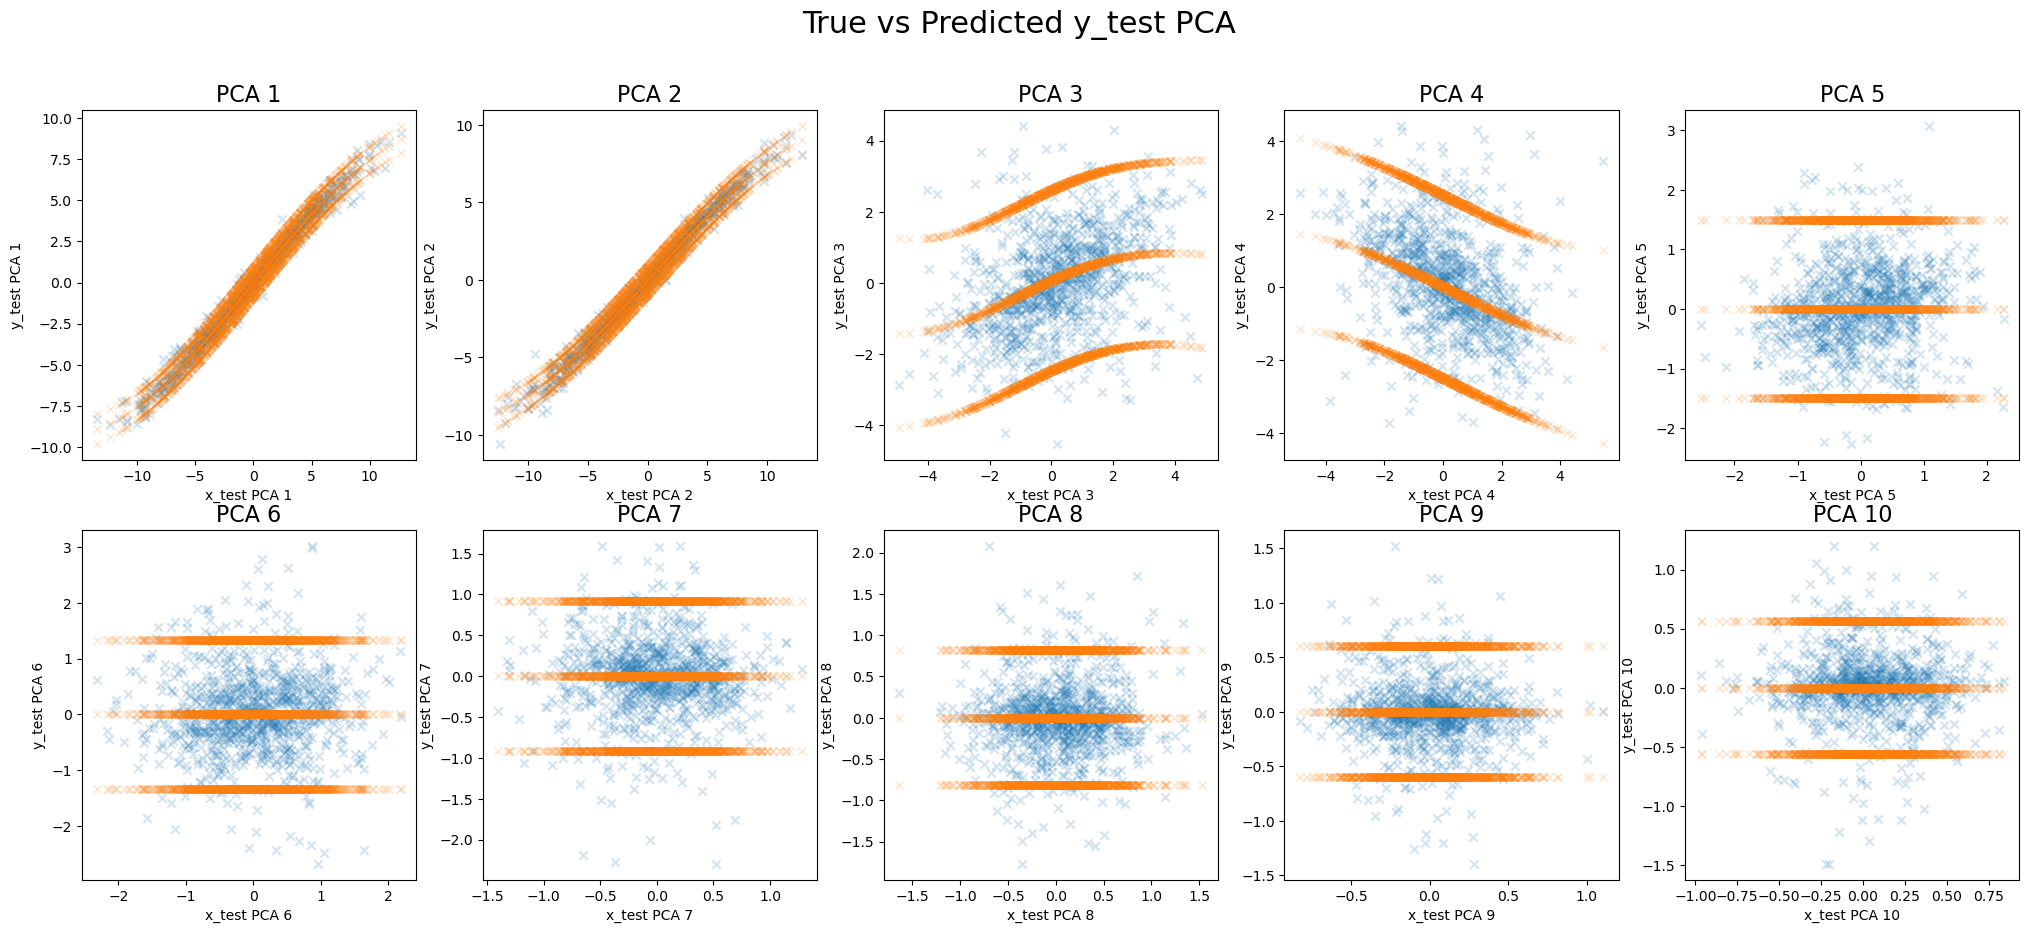

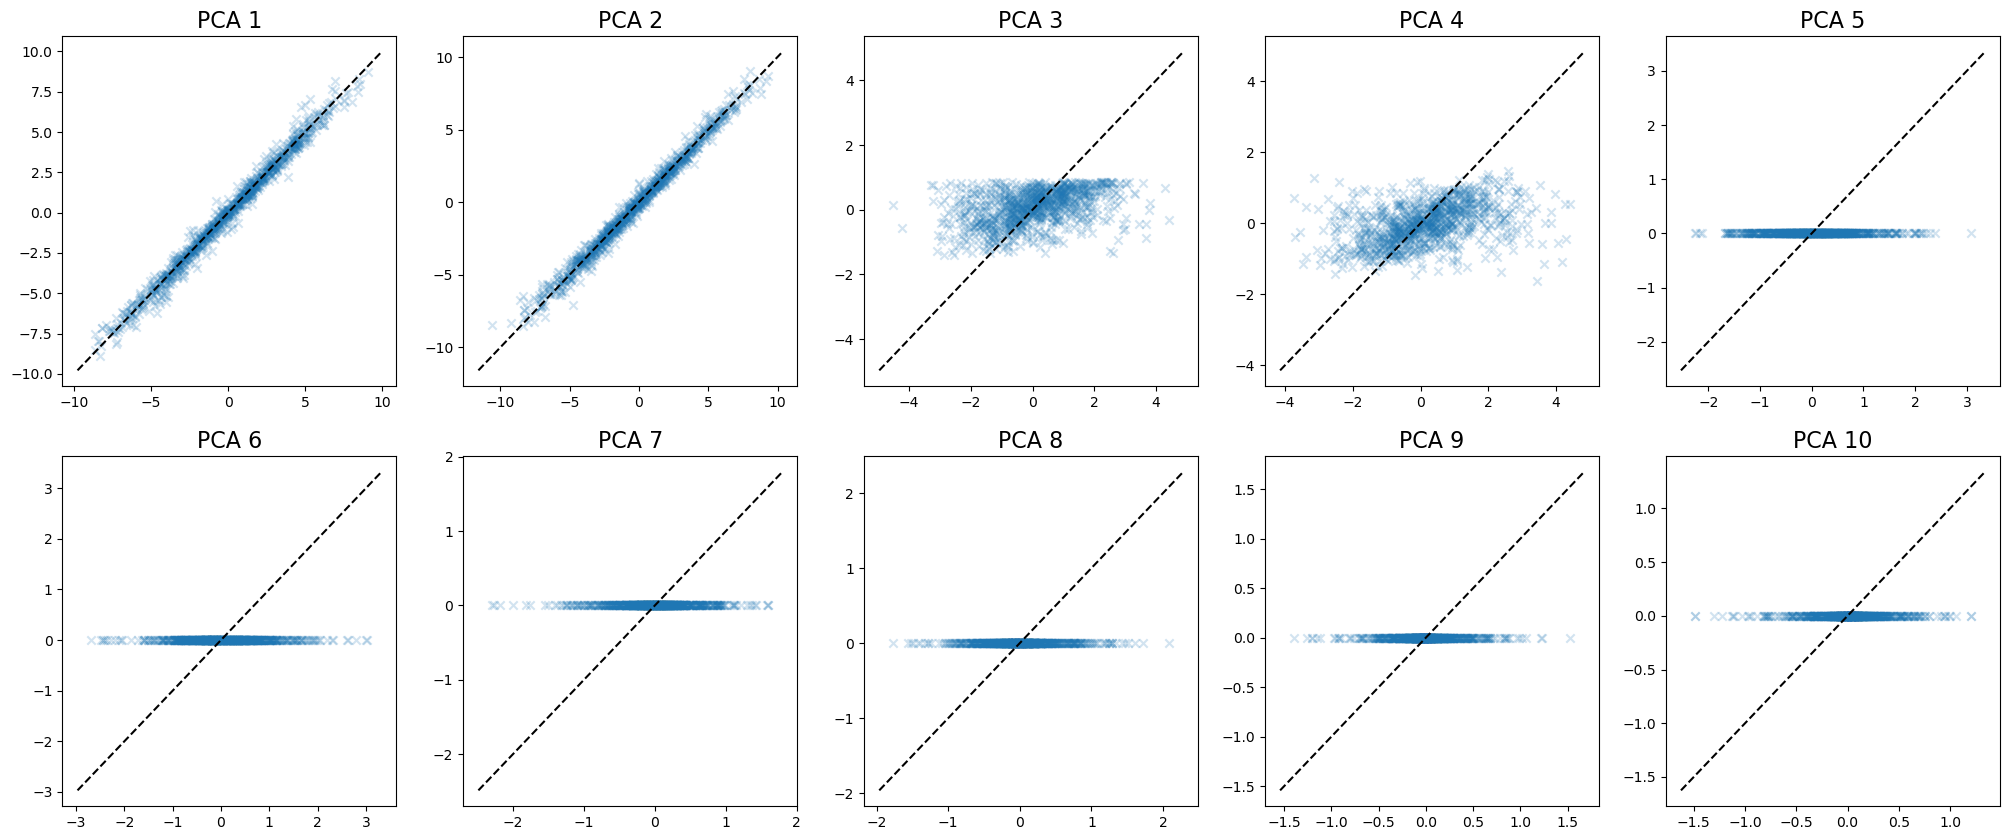

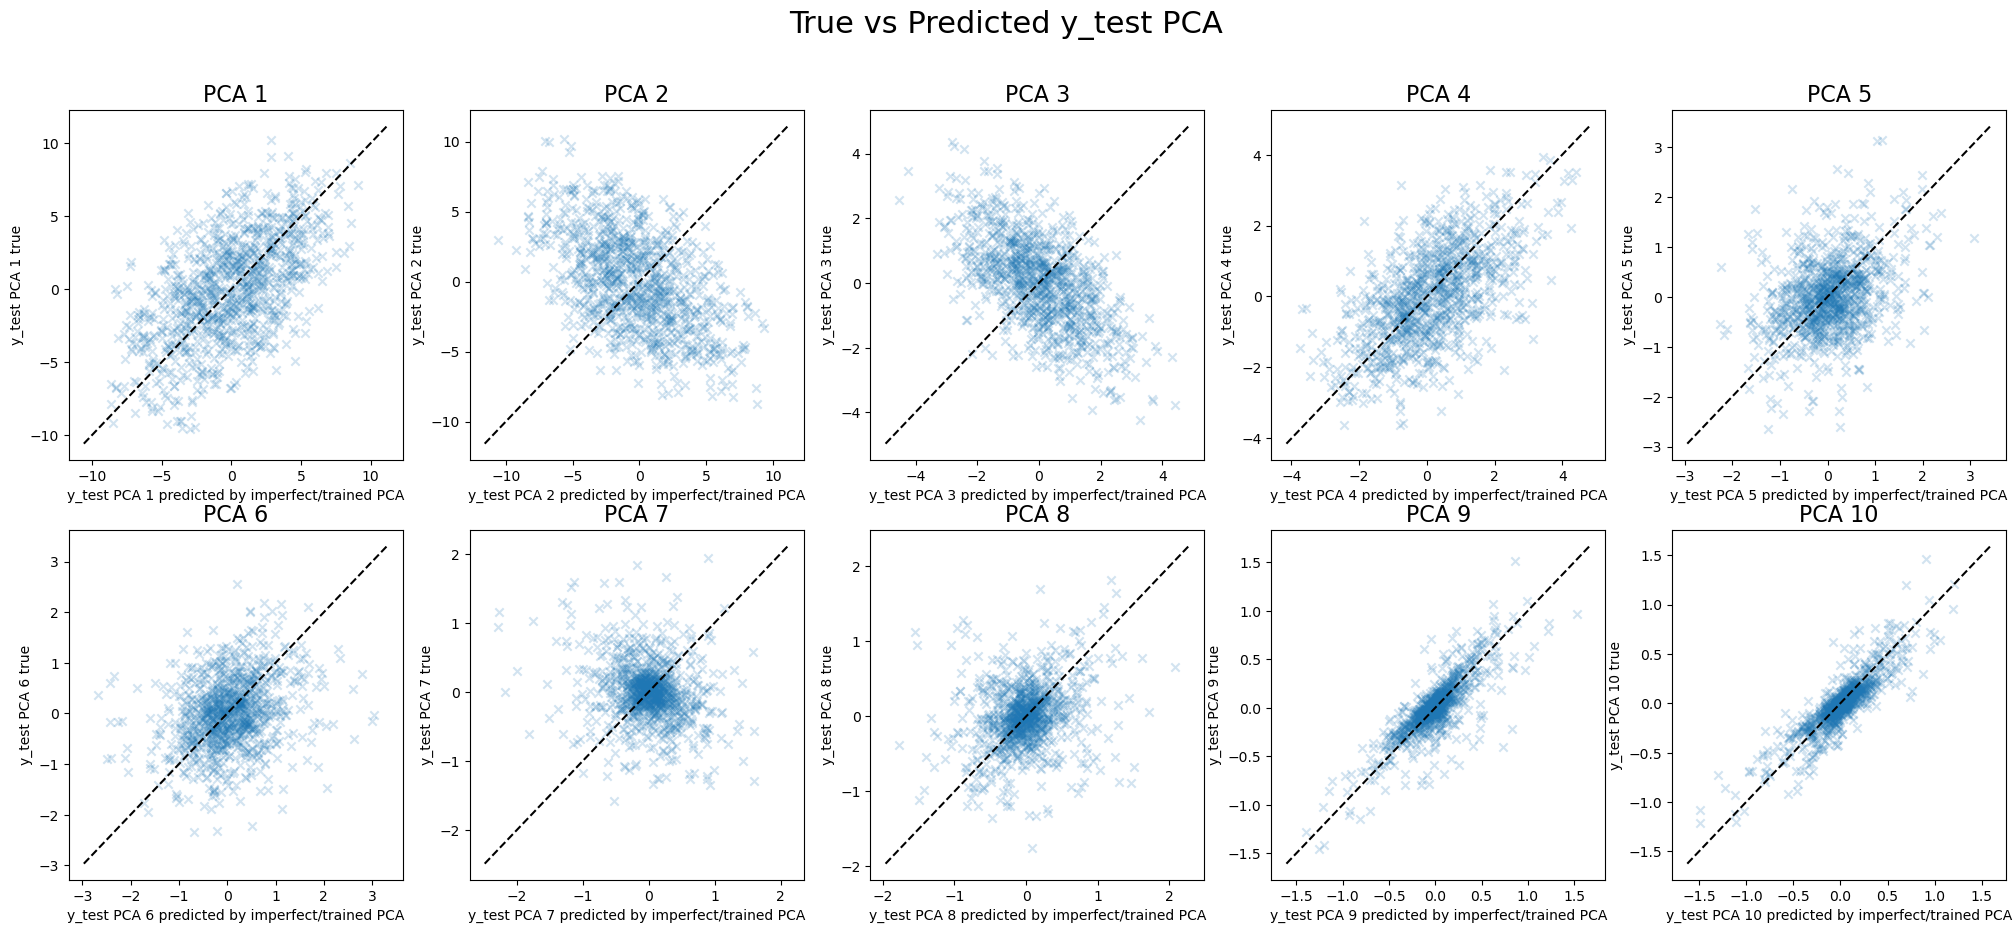

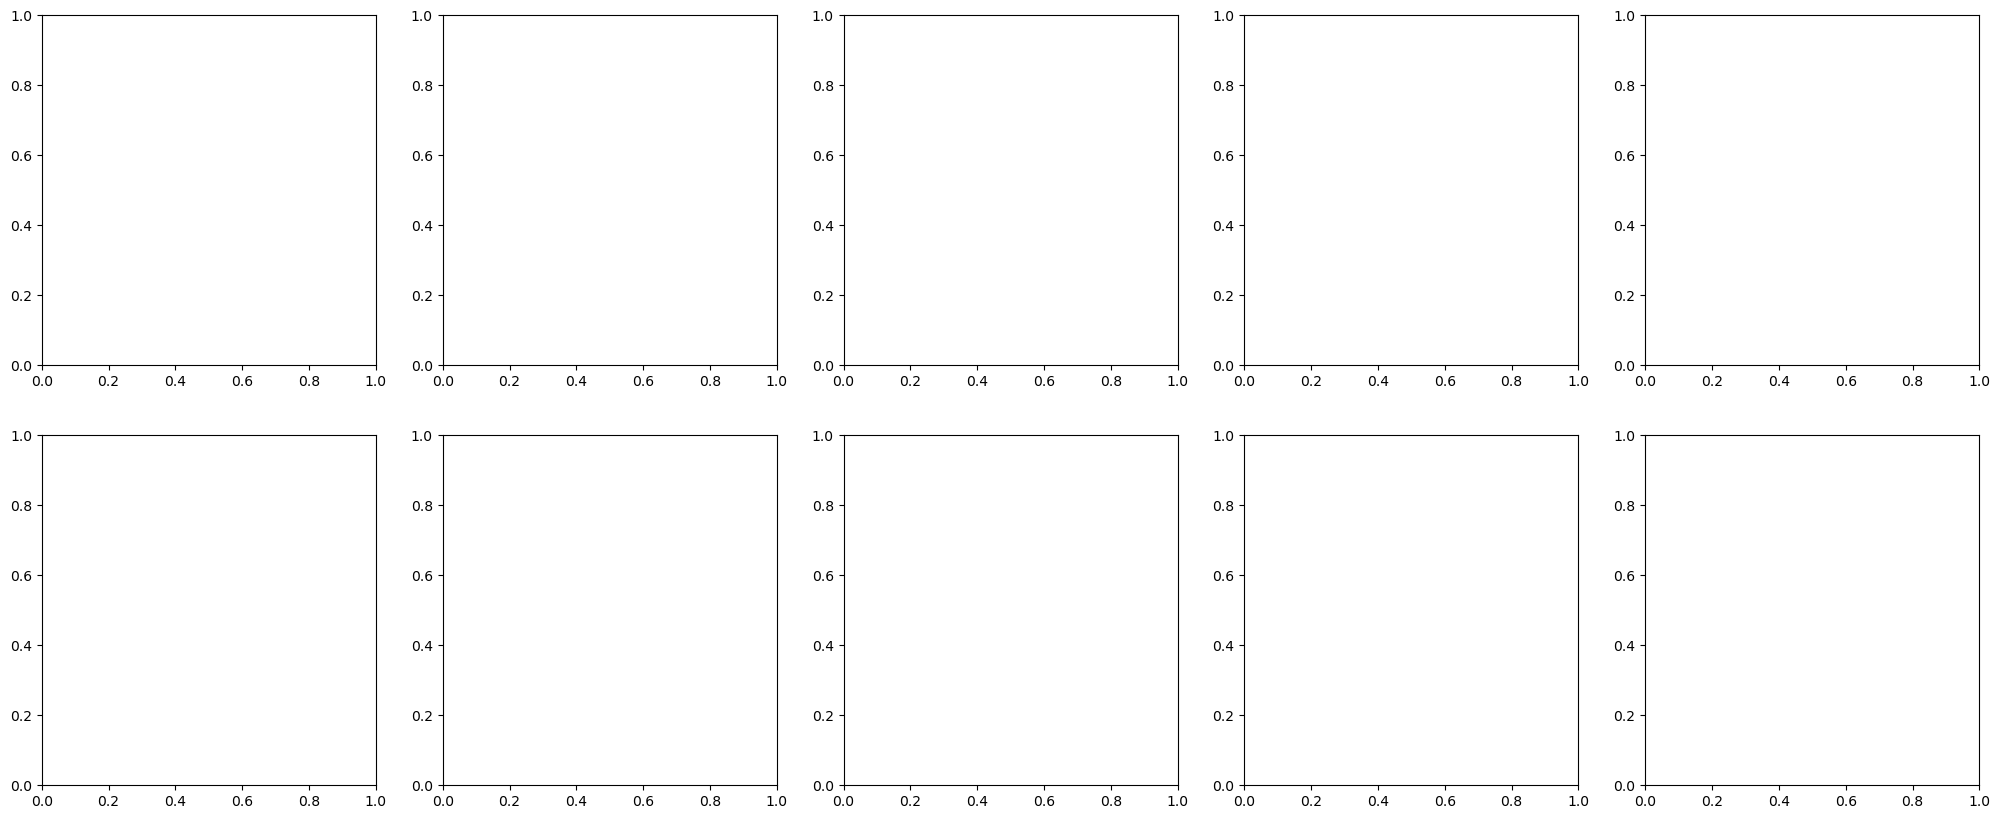

In [ ]:
# assess how well the low-dimensional regression is doing

y_test_pca = PCA(n_components=low_dim_y)
y_test_low_dim = y_test_pca.fit_transform(y_test) # get the "true" y_test in the low-dimensional space using a specifically-trained PCA
y_test_low_dim_approx = y_pca.transform(y_test)

n_rows = int(np.ceil(low_dim_y/5))

fig1, ax1 = plt.subplots(n_rows, 5, figsize=(25, n_rows*5))
fig2.suptitle('Univariate PCA predictions - test - imperfect/trained PCA', fontsize=22)

fig2, ax2 = plt.subplots(n_rows, 5, figsize=(25, n_rows*5))
fig1.suptitle('True vs Predicted y_test PCA', fontsize=22)

fig3, ax3 = plt.subplots(n_rows, 5, figsize=(25, n_rows*5))
fig3.suptitle('True vs Predicted y_test PCA', fontsize=22)

fig4, ax4 = plt.subplots(n_rows, 5, figsize=(25, n_rows*5))
fig4.suptitle('', fontsize=22)

for i in range(low_dim_y):
    if n_rows == 1:
        sli = int(i%5)
    else:
        sli = int(np.floor((i)/5)), int(i%5)

    # plot low_dim_regressions with the imperfect/trained y-PCA
    ax = ax1[sli]
    if low_dim_x == 1:
        ax.scatter(reg.X_test_low_dim[:, 0], y_test_low_dim_approx[:, i], marker='x', alpha=0.2) # plot low_dim_x against imperfect PCA low_dim_y
        ax.plot(reg.X_test_low_dim[:, 0], reg.Y_test_low_dim_pred[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2) # plot low_dim_x against predicted low_dim_y
        ax.plot(reg.X_test_low_dim[:, 0], reg.Y_test_low_dim_pred_upper[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.plot(reg.X_test_low_dim[:, 0], reg.Y_test_low_dim_pred_lower[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.set_title(f'y_test PCA {i+1}', fontsize=16)
        ax.set_xlabel('x_test PCA 1')
        ax.set_ylabel(f'y_test PCA {i+1}')
    elif not multiinput:
        ax.scatter(reg.X_test_low_dim[:, i], y_test_low_dim_approx[:, i], marker='x', alpha=0.2)
        ax.plot(reg.X_test_low_dim[:, i], reg.Y_test_low_dim_pred[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.plot(reg.X_test_low_dim[:, i], reg.Y_test_low_dim_pred_upper[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.plot(reg.X_test_low_dim[:, i], reg.Y_test_low_dim_pred_lower[:, i], color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        ax.set_xlabel(f'x_test PCA {i+1}')
        ax.set_ylabel(f'y_test PCA {i+1}')
        ax.set_title(f'PCA {i+1}', fontsize=16)


    mse = skl.metrics.mean_squared_error(y_test_low_dim[:, i], reg.Y_test_low_dim_pred[:, i])
    r = np.corrcoef(y_test_low_dim[:, i], reg.Y_test_low_dim_pred[:, i])

    # compare the imperfect y-PCA with predicted y-PCA
    ax = ax2[sli]
    ax.scatter(y_test_low_dim_approx[:, i], reg.Y_test_low_dim_pred[:, i], marker='x', alpha=0.2)
    ax.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
    # plt.xlabel(f'PCA {i+1} True')
    # plt.ylabel(f'PCA {i+1} Predicted')
    ax.set_title(f'PCA {i+1}', fontsize=16)

    # compare the imperfect PCA to the perfect PCA
    ax = ax3[sli]
    ax.scatter(y_test_low_dim_approx[:, i], y_test_low_dim[:, i], marker='x', alpha=0.2)
    ax.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
    ax.set_title(f'PCA {i+1}', fontsize=16)
    ax.set_xlabel(f'y_test PCA {i+1} predicted by imperfect/trained PCA')
    ax.set_ylabel(f'y_test PCA {i+1} true')

    # ax = ax4[int(np.floor((i)/5)), int(i%5)]
    # ax.scatter()
plt.show()


# for i in range(low_dim_y):
#     mse = skl.metrics.mean_squared_error(y_test_low_dim[:, i], reg.Y_test_low_dim_pred[:, i])
#     r = np.corrcoef(y_test_low_dim[:, i], reg.Y_test_low_dim_pred[:, i])

#     ax = ax1[int(np.floor((i)/5)), int(i%5)]
#     ax.scatter(y_test_low_dim[:, i], reg.Y_test_low_dim_pred[:, i], marker='x', alpha=0.2)
#     ax.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
#     # plt.xlabel(f'PCA {i+1} True')
#     # plt.ylabel(f'PCA {i+1} Predicted')
#     ax.set_title(f'PCA {i+1}', fontsize=16)
#     # plt.tight_layout()
#     # plt.subplots_adjust(top=0.95)
# plt.show()



Plot the distributions of errors (not sure if RMSE and R2 are the best here)

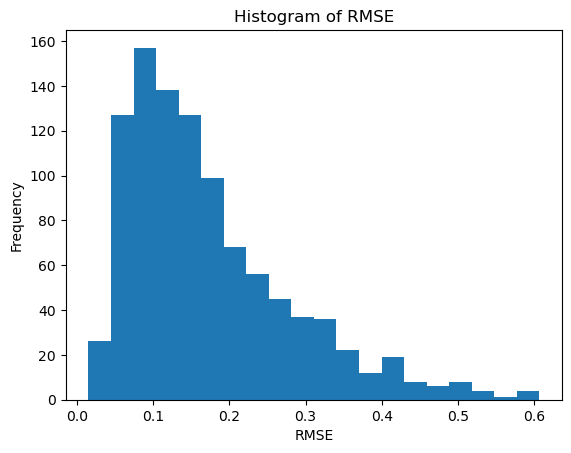

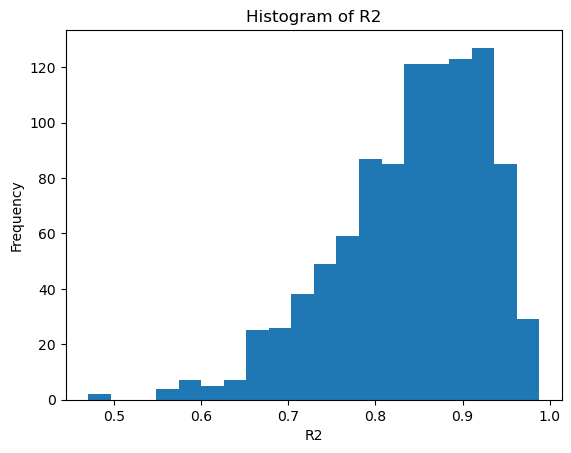

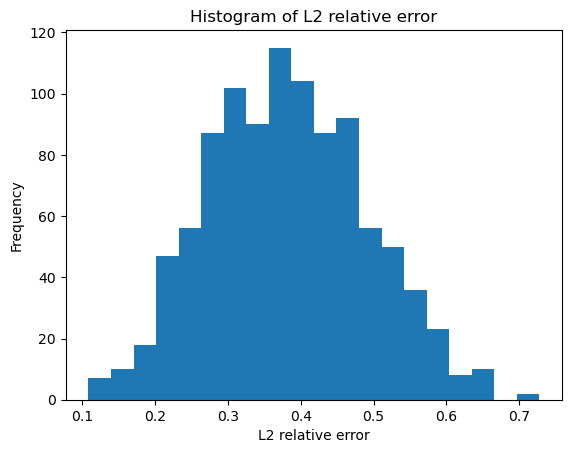

In [ ]:
plt.figure()
plt.hist(rmse, bins=20)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Histogram of RMSE')
plt.show()

plt.figure()
plt.hist(r2, bins=20)
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.title('Histogram of R2')
plt.show()

plt.figure()
plt.hist(L2_relative_error, bins=20)
plt.xlabel('L2 relative error')
plt.ylabel('Frequency')
plt.title('Histogram of L2 relative error')
plt.show()

plot an example test

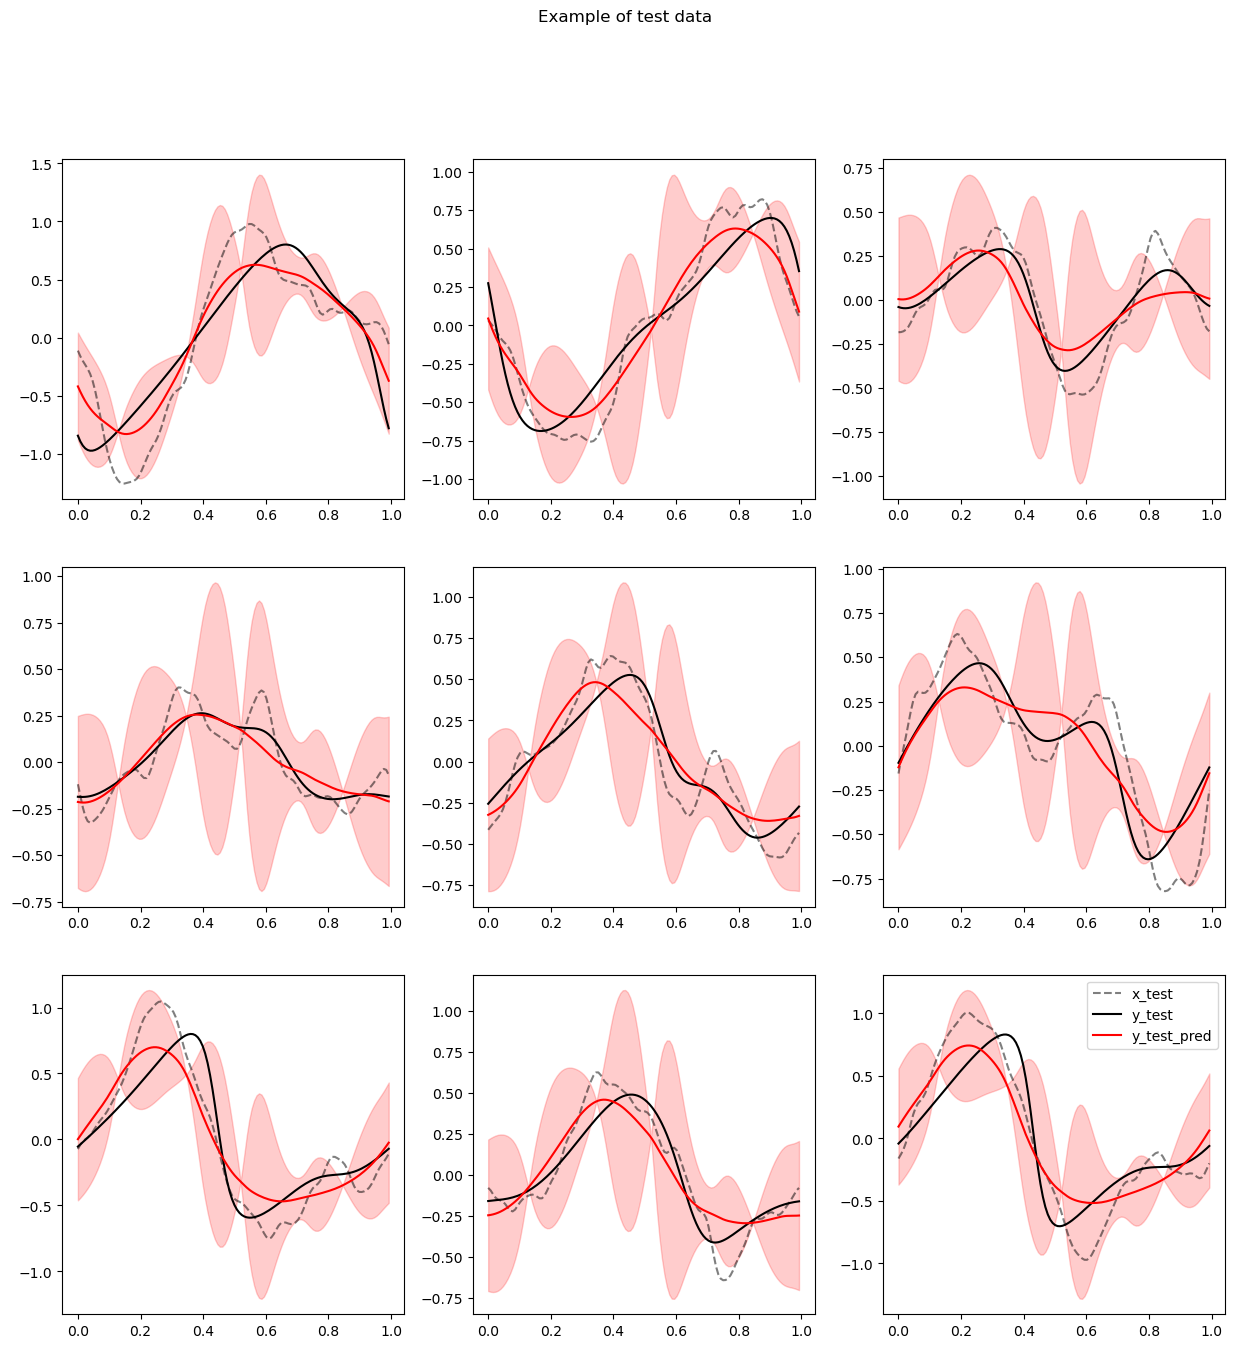

In [ ]:
index_to_plot = 127

fig1, ax1 = plt.subplots(3, 3, figsize=(15, 15))
fig1.suptitle('Example of test data')
for i in range(9):
    ax = ax1[int(np.floor((i)/3)), int(i%3)]
    ax.plot(x_test[1], x_test[0][i, :].T, label="x_test", linestyle='--', color='black', alpha=0.5)
    ax.plot(x_test[1], y_test[i, :].T, label="y_test", color='black')
    ax.plot(x_test[1], y_test_pred[i, :].T, label="y_test_pred", color='red')
    ax.fill_between(x_test[1][:, 0], y_test_pred_lower[i, :], y_test_pred_upper[i, :], color='red', alpha = 0.2)
    if i == 8:
        ax.legend()
    
plt.show()